In [1]:
import pandas
import numpy as np
from metrics import Metrics
from sklearn import metrics
import glob
import collections
import os
import json
from matplotlib import pyplot

In [2]:
from dataset import Dataset
dataset = Dataset(max_len=54, preshuffle=False, batch_size=10)
dataset.ReadData('/g/ssli/data/scotus/aaron/scotus_big.tsv.gz', ['case', 'person', 'role', 'text'], mode='eval', 
                splitter='word', limit=15000000)

loaded 216232 sentences


In [16]:
collections.Counter(dataset.data.person[dataset.data.role == 'justice'])

Counter({'anthony_kennedy': 4537,
         'anthony_m_kennedy': 96,
         'antonin_scalia': 10907,
         'byron_r_white': 30,
         'clarence_thomas': 19,
         'david_h_souter': 5781,
         'elena_kagan': 532,
         'harry_a_blackmun': 17,
         'john_g_roberts_jr': 5328,
         'john_paul_stevens': 3929,
         'ruth_bader_ginsburg': 6604,
         'samuel_a_alito_jr': 1298,
         'samuel_alito_jr': 126,
         'sandra_day_oconnor': 1997,
         'sonia_sotomayor': 1466,
         'stephen_g_breyer': 11453,
         'unidentified_justice': 122,
         'william_h_rehnquist': 3477})

In [34]:
subreddits = ['antonin_scalia', 'john_paul_stevens', 'anthony_kennedy',
       'david_h_souter', 'william_h_rehnquist', 'stephen_g_breyer',
       'sandra_day_oconnor', 'ruth_bader_ginsburg',
       'samuel_a_alito_jr', 'sonia_sotomayor', 'john_g_roberts_jr']

def MakePredictions(filename):
    df = pandas.read_csv(filename, index_col=0)
    
    df[subreddits] = df[subreddits].sub(df[subreddits].mean(axis=1), axis=0)
            
    ss = np.array(subreddits)
    df['pred'] = ss[np.argmin(df[subreddits].values, axis=1)]

    return df

In [35]:
def GetPPL(filename):
    dirname = os.path.dirname(filename)
    pplfile = os.path.join(dirname, 'ppl.txt')
    if os.path.exists(pplfile):
        with open(pplfile, 'r') as f:
          lines = f.readlines()
        if len(lines):
            ppl = lines[-1].split()[-1]
            return ppl
    return None

In [49]:
def GetParams(filename):
    dirname = os.path.dirname(filename)
    paramsfile = os.path.join(dirname, 'params.json')
    with open(paramsfile, 'r') as g:
        params = json.load(g)
    return params

In [51]:
def GetAuc(sub, df):
    fpr, tpr, thresholds = metrics.roc_curve(df.label == sub, -df[sub])
    return metrics.auc(fpr, tpr)

def PlotAuc(sub, df):
    fpr, tpr, thresholds = metrics.roc_curve(df.label == sub, -df[sub])
    pyplot.plot(fpr, tpr)

In [62]:
dataframes = {}
for filename in glob.glob('exps/scotuss*/classify.csv'):
    dataframes[filename] = MakePredictions(filename)

In [84]:
results = []
for filename in dataframes:
    row = {'model': filename}
    df = dataframes[filename]
    for sub in subreddits:
        row[sub] = GetAuc(sub, df)
    f1, acc = Metrics(list(df.pred.values), list(df.label.values), show=False)
    row['f1'] = f1
    row['acc'] = acc
    row['ppl'] = GetPPL(filename)
    
    params = GetParams(filename)
    row['hash'] = int(params['use_hash_table'])
    row['hyper'] = int(params['use_hyper_adaptation'])
    row['mikolov'] = int(params['use_mikolov_adaptation'])
    row['softmax'] = int(params['use_softmax_adaptation'])
    
    results.append(row)
results = pandas.DataFrame(results)
results['avg'] = results[subreddits].mean(axis=1)
results[results.model.apply(len) < 28].sort_values('ppl')[['acc', 'f1', 'avg', 'ppl', 'model',
                          'hyper', 'mikolov', 'softmax', 'hash']]

,acc,f1,avg,ppl,model,hyper,mikolov,softmax,hash
5,0.29525,26.609274,0.726500,29.244,exps/scotuss11/classify.csv,1,0,1,1
8,0.31875,28.757781,0.734104,29.443,exps/scotuss15/classify.csv,1,1,1,1
2,0.31100,28.352247,0.726616,29.760,exps/scotuss3/classify.csv,1,0,0,1
1,0.31125,28.288671,0.734596,29.769,exps/scotuss13/classify.csv,0,1,1,1
12,0.32425,29.629901,0.735690,29.778,exps/scotuss7/classify.csv,1,1,0,1
10,0.29850,26.815589,0.727265,29.882,exps/scotuss5/classify.csv,0,1,0,1
4,0.28400,25.744096,0.716749,30.006,exps/scotuss9/classify.csv,0,0,1,1
7,0.29575,27.041914,0.723797,31.166,exps/scotuss1/classify.csv,0,0,0,1
0,0.26125,21.625936,0.661913,32.231,exps/scotuss14/classify.csv,1,1,1,0
13,0.24450,19.955781,0.657869,32.275,exps/scotuss10/classify.csv,1,0,1,0


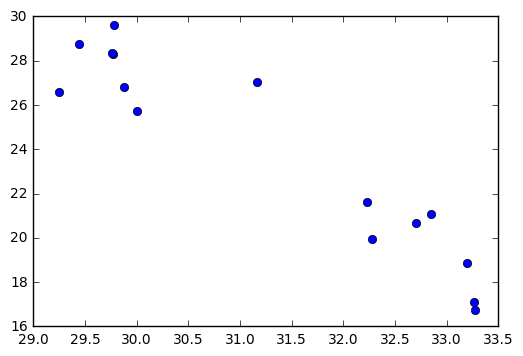

In [69]:
pyplot.plot(results.ppl, results.f1, 'o')
pyplot.show()

In [65]:
df = dataframes['exps/scotuss7/classify.csv']
Metrics(list(df.pred.values), list(df.label.values));

accuracy = 0.324
 Lang     Prec.   Rec.   F1
------------------------------
  anthony_kennedy   25.38  25.70  25.54
  antonin_scalia   46.12  28.46  35.20
  david_h_souter   30.52  29.02  29.75
  john_g_roberts_jr   37.54  30.29  33.53
  john_paul_stevens   23.30  31.42  26.75
  ruth_bader_ginsburg   36.83  30.84  33.57
  samuel_a_alito_jr   12.19  41.98  18.89
  sandra_day_oconnor   14.01  33.85  19.82
  sonia_sotomayor   11.32  27.27  16.00
  stephen_g_breyer   52.26  35.62  42.36
  william_h_rehnquist   38.18  53.39  44.52
------------------------------
  Total:   29.79  33.44  29.63


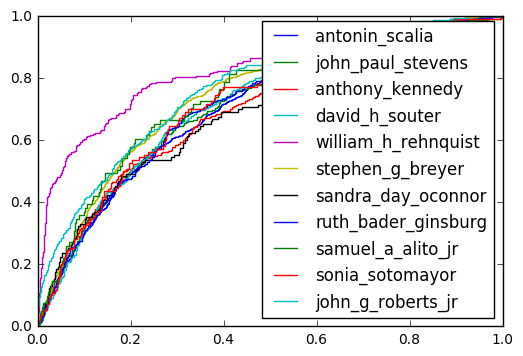

In [66]:
for sub in subreddits:
    fpr, tpr, thresholds = metrics.roc_curve(df.label == sub, -df[sub])
    pyplot.plot(fpr, tpr)


pyplot.legend(subreddits, loc=4)

"""pyplot.semilogy()
pyplot.semilogx()
pyplot.xlim([0.001, 1.0])
pyplot.ylim([0.1, 1.0])"""
pyplot.show()

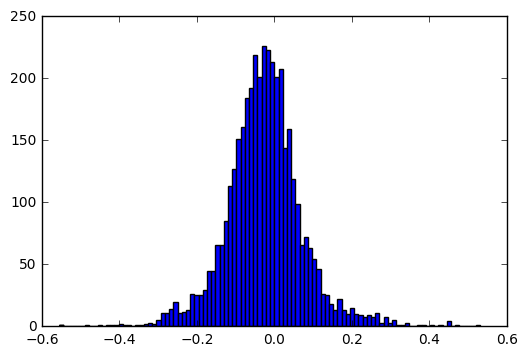

In [83]:
pyplot.hist(df['antonin_scalia'], bins=100)
pyplot.show()

In [77]:
counts = np.array(collections.Counter(df.label.values).values())
counts = counts / float(counts.sum())

In [81]:
np.exp(-(counts * np.log(counts)).sum())

8.9163858268665948

In [82]:
counts

array([ 0.0965 ,  0.21125,  0.09325,  0.0275 ,  0.11675,  0.02025,
        0.19325,  0.0325 ,  0.06525,  0.08075,  0.06275])